<a href="https://colab.research.google.com/github/Maqar/DL/blob/main/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 34.3 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 636 kB 45.8 MB/s 
     |████████████████████████████████| 3.3 MB 39.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import transformers

In [ ]:
transformers.__version__

In [3]:
import numpy as np
from scipy.spatial import distance
import pandas as pd
import networkx as nx
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import requests
from tqdm.auto import tqdm
from sklearn.metrics import classification_report

In [4]:
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTModel

In [19]:
# transform = transforms.Compose(
#      [
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#      ])

batch_size = 500

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [21]:
feature_extractor = ViTFeatureExtractor.from_pretrained('nateraw/vit-base-patch16-224-cifar10', do_normalize=True, do_resize=True)
model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10', output_hidden_states = True)
model.eval();

In [7]:
model_feature = ViTModel.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
model_feature.eval();

Some weights of the model checkpoint at nateraw/vit-base-patch16-224-cifar10 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-patch16-224-cifar10 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Check accuracy on test set

In [ ]:
pred = []
true = []

i = 0

with torch.no_grad(): 
    for x, y in tqdm(testset):
        true.append(y)
        model_input = feature_extractor(images=np.array(x), return_tensors="pt")
        output = model(**model_input)
        logits = output.logits
        predicted_class_idx = logits.argmax(-1).item()

        pred.append(predicted_class_idx)
        
        #i += 1
        
        #if i > 100:
            #break
            
print(classification_report(true, pred))

Получаем признаки картинок из модели


In [ ]:
  feat = []
  target = []

  with torch.no_grad():
      for x, y in tqdm(trainloader):
          # calculate outputs by running images through the network
          target.append(y)
          # output = model_feature(x)
          input = feature_extractor(x, return_tensors="pt")
          output = model_feature(**input)
          feat.append(output[1][0])



Делаем словарь {label: усредненный вектор}

In [ ]:
# def func(target):

#     l = []
#     c = 0

#     with torch.no_grad():
#         for i in range(len(trainset)):
#             if trainset[i][1] == target:

#                 image = trainset[i][0]
#                 inputs = feature_extractor(images = np.array(image), return_tensors="pt")
#                 y = model_feature(**inputs)

#                 if c == 0:
#                     l = y[1][0]
#                 else:
#                     l += y[1][0]
#                 c += 1
#                 print(c)

# return l/5000


In [ ]:
#Создание матрицы смежности и графа

In [ ]:
#находим косинусное расстояние
cos_dist_matrix = distance.cdist(LIST, LIST, 'cosine') #LIST набор усредненных векторов классов
#находим среднее (не учитываем 0)
mean = np.mean(np.true_divide(cos_dist_matrix.sum(1),(cos_dist_matrix > 0.01).sum(1)))
#преобразуем в матрицу смежности
m = np.where(cos_dist_matrix > mean, 1, 0)

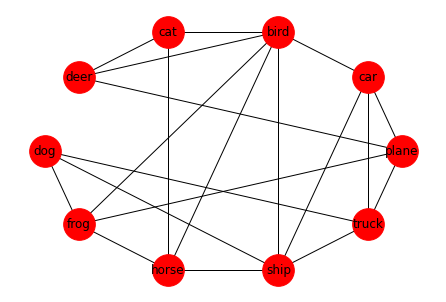

In [ ]:
#создаем граф смежности
M = pd.DataFrame(m, index=classes, columns=classes)

G = nx.from_pandas_adjacency(M)

nx.draw_circular(G,
         node_color='red',
         node_size=1000,
         with_labels=True)